# Start exploring prediction for miscentered cluster

This follows the equations from the [cluster-toolkit documentation](https://cluster-toolkit.readthedocs.io/en/latest/source/miscentering.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm import Cosmology
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy.special import gamma, gammainc

In [2]:
cosmo = Cosmology(H0=70.0, Omega_dm0=0.3-0.045, Omega_b0=0.045, Omega_k0=0.0)

In [3]:
moo = clmm.Modeling(massdef='mean', delta_mdef=200, halo_profile_model='einasto')

moo.set_cosmo(cosmo)
moo.set_concentration(5)
moo.set_mass(1.e14)

z_cl = 0.1

# for the CCL backend
alpha_ein = 0.25
if moo.halo_profile_model == 'einasto':
    moo.set_einasto_alpha(alpha_ein)

In [4]:
def R_from_true(theta, R, Roff):
    return np.sqrt(R*R + Roff*Roff - 2*R*Roff*np.cos(theta))

def integrand1(theta, R, Roff):
    return moo.eval_surface_density(R_from_true(theta, R, Roff), z_cl)/(2*np.pi)

# Sigma exact
def Sigma_mis_exact(R, Roff):    
    return integrate.quad_vec(integrand1, 0., 2*np.pi, args=(R, Roff))[0]

# Sigma mean exact
def integrand_Sigmamean_exact(Rprime, Roff):    
    return Rprime * Sigma_mis_exact(Rprime, Roff)

In [5]:
def integrand1_opt(theta, R, Roff):
    return moo.eval_surface_density(R_from_true(theta, R, Roff), z_cl)

c200 = moo.cdelta
rho_def = moo.cosmo.get_rho_m(z_cl)
r_s = moo.eval_rdelta(z_cl) / c200
rho_s_nfw = moo.delta_mdef/3.*c200**3.*rho_def/(np.log(1.+c200)-c200/(1.+c200))
rho_s_ein = moo.delta_mdef/3.*c200**3.*rho_def/(2.**(-3./alpha_ein) * alpha_ein**(-1.+3./alpha_ein) * np.exp(2./alpha_ein) * gamma(3./alpha_ein) * gammainc(3./alpha_ein, 2./alpha_ein*c200**alpha_ein))
rho_s_her = moo.delta_mdef/3.*c200**3.*rho_def/((c200/(1. + c200))**2.)*2

# can do the same for the Hernquist profile too
def integrand1_opt_nfw(theta, R, Roff):
    x = np.sqrt(R**2. + Roff**2. - 2.*R*Roff*np.cos(theta)) / r_s
    xx = x**2
    if x < 1:
        res = (np.arccosh(1./x)/(1.-xx)**(3./2.)-1./(1.-xx))
    elif x > 1:
        res = (-np.arccos(1./x)/(xx-1.)**(3./2.)+1./(xx-1.))
    else:
        res = 1./3.
    res *= 2. * r_s * rho_s_nfw
    return res

def integrand1_opt_ein(theta, R, Roff):
    def integrand0(z):
        x = np.sqrt(z**2. + R**2. + Roff**2. - 2.*R*Roff*np.cos(theta)) / r_s
        return np.exp(-2. * (x**alpha_ein - 1.) / alpha_ein)
    return integrate.quad_vec(integrand0, 0., np.inf)[0] * 2. * rho_s_ein

def integrand1_opt_her(theta, R, Roff):
    x = np.sqrt(R**2. + Roff**2. - 2.*R*Roff*np.cos(theta)) / r_s
    x2m1 = x**2. - 1.
    if x < 1:
        res = (-3 / x2m1**2
               + (x2m1+3) * np.arccosh(1 / x) / (-x2m1)**2.5)
    elif x > 1:
        res = (-3 / x2m1**2
               + (x2m1+3) * np.arccos(1 / x) / (x2m1)**2.5)
    else:
        res = 4./15.
    res *= r_s * rho_s_her
    return res

# Sigma exact
def Sigma_mis_exact_opt(R, Roff):    
    return integrate.quad_vec(integrand1_opt, 0., np.pi, args=(R, Roff))[0]/np.pi

def Sigma_mis_exact_opt_nfw(R, Roff):    
    return integrate.quad_vec(integrand1_opt_nfw, 0., np.pi, args=(R, Roff))[0]/np.pi

def Sigma_mis_exact_opt_ein(R, Roff):    
    return integrate.quad_vec(integrand1_opt_ein, 0., np.pi, args=(R, Roff))[0]/np.pi

def Sigma_mis_exact_opt_her(R, Roff):    
    return integrate.quad_vec(integrand1_opt_her, 0., np.pi, args=(R, Roff))[0]/np.pi

# Sigma mean exact
def integrand_Sigmamean_exact_opt(Rprime, Roff):    
    return Rprime * Sigma_mis_exact_opt(Rprime, Roff)

def integrand_Sigmamean_exact_opt_nfw(Rprime, Roff):
    return Rprime * Sigma_mis_exact_opt_nfw(Rprime, Roff)

def integrand_Sigmamean_exact_opt_ein(Rprime, Roff):
    return Rprime * Sigma_mis_exact_opt_ein(Rprime, Roff)

def integrand_Sigmamean_exact_opt_her(Rprime, Roff):
    return Rprime * Sigma_mis_exact_opt_her(Rprime, Roff)

In [6]:
def Sigma_mean_mis_exact(R_arr, Roff):
    res=[]
    for i,R in enumerate(R_arr):
        res.append(integrate.quad(integrand_Sigmamean_exact, 0., R, args=(Roff))[0]*2./R/R)
    return np.array(res)

def Sigma_mean_mis_exact_opt(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.quad(integrand_Sigmamean_exact_opt, R_lower, R, args=(Roff))[0]
    res = np.cumsum(res)*2/R_arr**2
    return res

def Sigma_mean_mis_exact_opt_nfw(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.quad(integrand_Sigmamean_exact_opt_nfw, R_lower, R, args=(Roff))[0]
    res = np.cumsum(res)*2/R_arr**2
    return res

def Sigma_mean_mis_exact_opt_ein(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.quad(integrand_Sigmamean_exact_opt_ein, R_lower, R, args=(Roff))[0]
    res = np.cumsum(res)*2/R_arr**2
    return res

def Sigma_mean_mis_exact_opt_her(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.quad(integrand_Sigmamean_exact_opt_her, R_lower, R, args=(Roff))[0]
    res = np.cumsum(res)*2/R_arr**2
    return res

def Sigma_mean_mis_trap(R_arr, Roff, regrid=10):
    # use finer grid that R_arr to evaluate integral, for precision purpose. Controld by the regrid parameter. 
    new_R_arr = np.logspace(np.log10(1.e-5), np.log10(R_arr.max()), regrid)
    
    res = (2./new_R_arr**2) * integrate.cumulative_trapezoid(new_R_arr * Sigma_mis_exact(new_R_arr, Roff), new_R_arr, initial=0)
    
    f = interp1d(new_R_arr, res)
    return f(R_arr)


def DS_mis_approx(R_arr, Roff, regrid=1000): 
    return Sigma_mean_mis_trap(R_arr, Roff, regrid=regrid) - Sigma_mis_exact(R_arr, Roff)

def DS_mis_exact(R_arr, Roff): 
    return Sigma_mean_mis_exact(R_arr, Roff) - Sigma_mis_exact(R_arr, Roff)

def DS_mis_exact_opt(R_arr, Roff): 
    return Sigma_mean_mis_exact_opt(R_arr, Roff) - Sigma_mis_exact_opt(R_arr, Roff)

def DS_mis_exact_opt_nfw(R_arr, Roff): 
    return Sigma_mean_mis_exact_opt_nfw(R_arr, Roff) - np.array([Sigma_mis_exact_opt_nfw(R_, Roff) for R_ in R_arr])
    
def DS_mis_exact_opt_ein(R_arr, Roff): 
    return Sigma_mean_mis_exact_opt_ein(R_arr, Roff) - Sigma_mis_exact_opt_ein(R_arr, Roff)

def DS_mis_exact_opt_her(R_arr, Roff): 
    return Sigma_mean_mis_exact_opt_her(R_arr, Roff) - np.array([Sigma_mis_exact_opt_her(R_, Roff) for R_ in R_arr])

In [7]:
Roff = 0.2
R_arr = np.logspace(-2, 1, 50)

In [8]:
Sigma_mis = Sigma_mis_exact_opt(R_arr, Roff)

In [9]:
%%time
DeltaSigma_mis_exact = DS_mis_exact(R_arr, Roff)
# won't finish (or takes very long) for CCL Einasto

CPU times: user 4min 5s, sys: 2.06 s, total: 4min 7s
Wall time: 4min 11s


In [10]:
%%time
DeltaSigma_mis_exact_opt = DS_mis_exact_opt(R_arr, Roff)
# won't finish (or takes very long) for CCL Einasto

CPU times: user 9.37 s, sys: 150 ms, total: 9.52 s
Wall time: 9.66 s


In [11]:
%%time
DeltaSigma_mis_exact_opt_ein = DS_mis_exact_opt_ein(R_arr, Roff)
# NC Einasto and CCL Einasto have similar performance
# Won't finish for Hernquist profile due to discontinuity

CPU times: user 3min 8s, sys: 1.94 s, total: 3min 10s
Wall time: 3min 12s


In [12]:
np.abs(DeltaSigma_mis_exact_opt/DeltaSigma_mis_exact-1).max()

5.839551175945701e-09

In [13]:
np.abs(DeltaSigma_mis_exact_opt_ein/DeltaSigma_mis_exact_opt-1).max()

2.9876851059817966e-07

In [14]:
%%time
DeltaSigma_mis_1e2 = DS_mis_approx(R_arr, Roff, regrid=100)

CPU times: user 325 ms, sys: 5.16 ms, total: 330 ms
Wall time: 332 ms


In [15]:
%%time 
DeltaSigma_mis_1e3 = DS_mis_approx(R_arr, Roff, regrid=1000)

CPU times: user 1.84 s, sys: 7.71 ms, total: 1.85 s
Wall time: 1.85 s


In [16]:
%%time 
DeltaSigma_mis_1e4 = DS_mis_approx(R_arr, Roff, regrid=10000)

CPU times: user 18.3 s, sys: 137 ms, total: 18.4 s
Wall time: 18.6 s


In [17]:
Sigma = moo.eval_surface_density(R_arr, z_cl)
DeltaSigma = moo.eval_excess_surface_density(R_arr, z_cl)

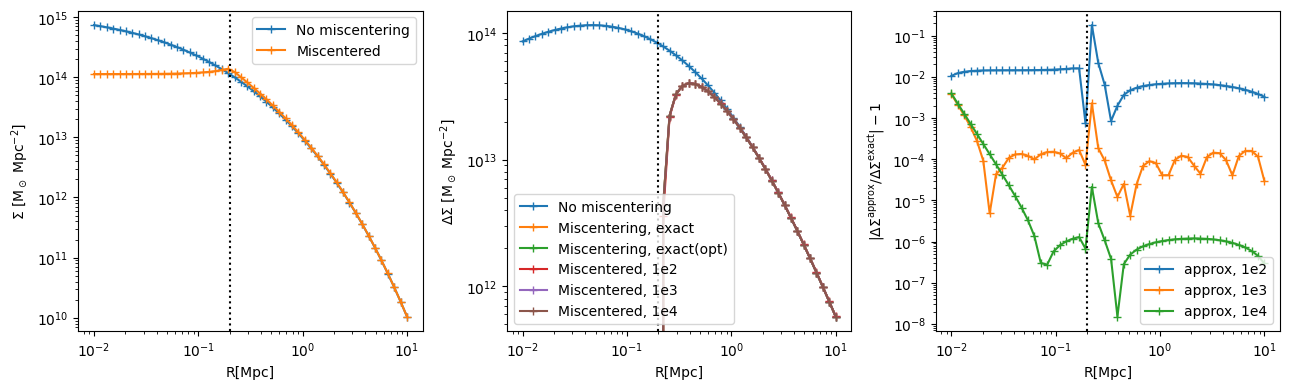

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(13,4))
axes[0].loglog(R_arr, Sigma, label='No miscentering', marker='+')
axes[0].loglog(R_arr, Sigma_mis, label='Miscentered', marker='+')
axes[0].axvline(Roff, c='k', ls=':')
axes[0].set_xlabel('R[Mpc]')
axes[0].set_ylabel(r'$\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[1].loglog(R_arr, DeltaSigma, label='No miscentering', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_exact, label='Miscentering, exact', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_exact_opt, label='Miscentering, exact(opt)', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e2, label='Miscentered, 1e2', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e3, label='Miscentered, 1e3', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e4, label='Miscentered, 1e4', marker='+')
#axes[1].loglog(R_arr, DeltaSigma_mis_1e5, label='Miscentered, 1e5', marker='+')
axes[1].axvline(Roff, c='k', ls=':')
axes[1].legend()
axes[1].set_xlabel('R[Mpc]')
axes[1].set_ylabel(r'$\Delta\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e2/DeltaSigma_mis_exact)-1), marker='+', label='approx, 1e2')
axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e3/DeltaSigma_mis_exact)-1), marker='+', label='approx, 1e3')
axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e4/DeltaSigma_mis_exact)-1), marker='+', label='approx, 1e4')
axes[2].axvline(Roff, c='k', ls=':')
axes[2].set_xlabel('R[Mpc]')
axes[2].set_ylabel(r'$|\Delta\Sigma^{\rm approx}/\Delta\Sigma^{\rm exact}|-1$')


axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()

In [19]:
Roff = 0.2

In [20]:
def Roff_distrib(Roff, Rmis=0.2):
    return np.exp(-Roff/Rmis) * Roff/(Rmis*Rmis)

def integrand_Sigmastack_mean_exact(Rprime, Roff): 
    return Rprime * Sigma_stack_mis_exact(Rprime, Roff)

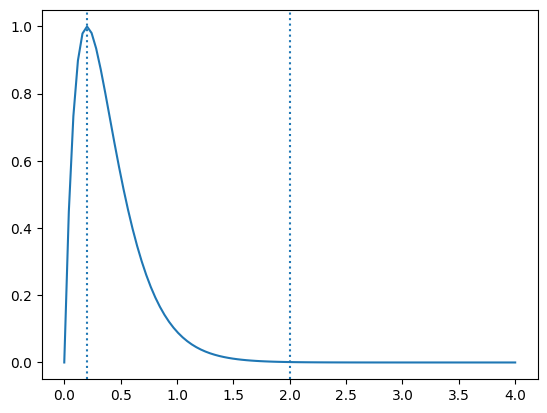

In [21]:
Roff_arr = np.linspace(0,20*Roff,100)
plt.plot(Roff_arr, Roff_distrib(Roff_arr, Rmis=Roff)/Roff_distrib(Roff, Rmis=Roff))
plt.axvline(Roff, linestyle=':')
plt.axvline(10.*Roff, linestyle=':')

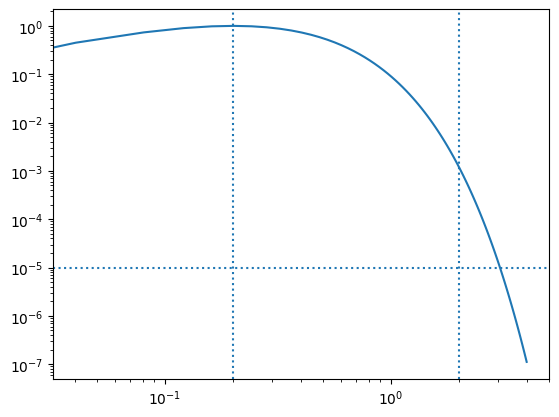

In [22]:
plt.loglog(Roff_arr, Roff_distrib(Roff_arr, Rmis=Roff)/Roff_distrib(Roff, Rmis=Roff))
plt.axvline(Roff, linestyle=':')
plt.axvline(10.*Roff, linestyle=':')
plt.axhline(1.e-5, linestyle=':')

In [23]:
R_arr_int = np.logspace(-5,4,100)

In [24]:
def Sigma_mis_interp(R, Roff):
    Sigma_mis = Sigma_mis_exact(R_arr_int, Roff)
    f_sigmamis = interp1d(R_arr_int, Sigma_mis)
    return f_sigmamis(R)

In [25]:
def integrand_stack(Roff, R, Rmis):
    return Sigma_mis_interp(R, Roff) * Roff_distrib(Roff, Rmis)

def integrand_stack_tab(Roff_tab, R, Rmis):
    res = []
    for r in Roff_tab:
        res.append(Sigma_mis_interp(R, r) * Roff_distrib(r, Rmis))
    return np.array(res)

def Sigma_stack_mis_quad(R_arr, Rmis=3.):
    return integrate.quad_vec(integrand_stack, 1.e-5, 1.e5, args=(R, Rmis))[0]

def Sigma_stack_mis_simps(R_arr, Rmis, Rinfty_scale=10, ngrid=100):
    Roff_tab = np.linspace(0.,Rmis*Rinfty_scale,ngrid)
    tab = integrand_stack_tab(Roff_tab, R_arr, Rmis)
    return integrate.simpson(tab, Roff_tab, axis=0)

In [26]:
Sigma_mis_stack_simps = Sigma_stack_mis_simps(R_arr, Rmis=Roff)

In [27]:
def Sigma_mean_mis_stack_trap(R_arr, Rmis, ngrid=100, Rinfty_scale=10, ngrid_sigma=100):
    
    new_R_arr = np.logspace(np.log10(1.e-5), np.log10(R_arr.max()), ngrid)
    res = (2./new_R_arr**2) * integrate.cumulative_trapezoid(new_R_arr * Sigma_stack_mis_simps(new_R_arr, Rmis, Rinfty_scale=Rinfty_scale, ngrid=ngrid_sigma), new_R_arr, initial=0)
    
    f = interp1d(new_R_arr, res)
    return f(R_arr)

In [28]:
Roff=0.2
R_arr2 = np.logspace(-2,np.log10(20),50)

Sigma = moo.eval_surface_density(R_arr2, z_cl)
Sigma_mis = Sigma_mis_exact(R_arr2, Roff)

In [29]:
DeltaSigma = moo.eval_excess_surface_density(R_arr2, z_cl)
DeltaSigma_mis = DS_mis_approx(R_arr2, Roff, regrid=1000)

In [30]:
Sigma_mis_stack = Sigma_stack_mis_simps(R_arr2, Rmis=Roff, Rinfty_scale=10, ngrid=1000)
Sigma_mean_stack_mis_trap = Sigma_mean_mis_stack_trap(R_arr2, Rmis=Roff, ngrid=1000, Rinfty_scale=10, ngrid_sigma=1000)
DeltaSigma_stack_mis = Sigma_mean_stack_mis_trap - Sigma_mis_stack

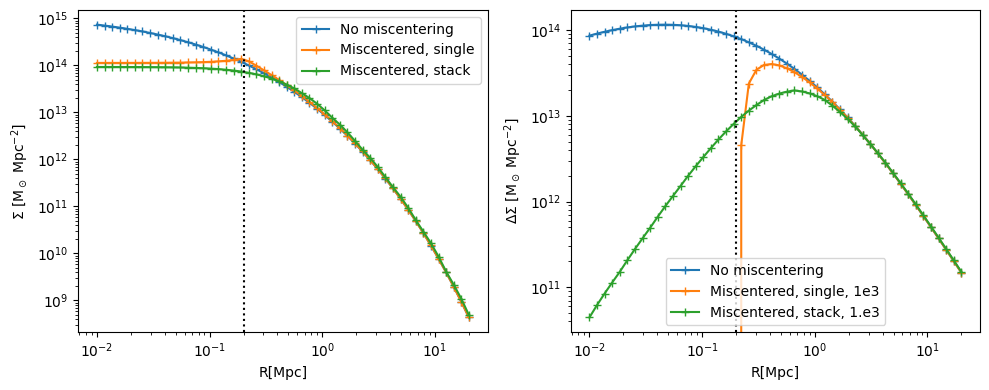

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].loglog(R_arr2, Sigma, label='No miscentering', marker='+')
axes[0].loglog(R_arr2, Sigma_mis, label='Miscentered, single', marker='+')
axes[0].loglog(R_arr2, Sigma_mis_stack, label='Miscentered, stack', marker='+')
axes[0].axvline(Roff, c='k', ls=':')
axes[0].set_xlabel('R[Mpc]')
axes[0].set_ylabel(r'$\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[1].loglog(R_arr2, DeltaSigma, label='No miscentering', marker='+')
axes[1].loglog(R_arr2, DeltaSigma_mis, label='Miscentered, single, 1e3', marker='+')
axes[1].loglog(R_arr2, DeltaSigma_stack_mis, label='Miscentered, stack, 1.e3', marker='+')
axes[1].axvline(Roff, c='k', ls=':')
axes[1].legend()
axes[1].set_xlabel('R[Mpc]')
axes[1].set_ylabel(r'$\Delta\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[0].legend()
axes[1].legend()

fig.tight_layout()